### Este notebook se concentra em compilar os resultados de simulações das implementações do algoritmo SVM sem e com a utilização de tecnicas de feature scaling

In [1]:
#importação das bibliotecas
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.svm import SVR
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, root_mean_squared_error

In [2]:
from utils import *

#### Implementações sem utilização de feature scaling

In [3]:
df = pd.read_csv(r'data\opticalnetwork_dataset.csv')

In [4]:
for channel in string_features:
  for key in coef_mod.keys():
    df[f'coef_mod_{channel}_{key}'] = df[channel].apply(lambda x: coef_mod[key][x])

In [5]:
df.Spans_Fn = df.Spans_Fn.apply(lambda x: 10*np.log10(x))

In [6]:
features = [feature for feature in df.columns if feature not in output_features+zero_features+string_features+const_input_features]

In [7]:
colunas = ['NumCh', 'NumSpans', 'DispPar', 'Spans_gamma', 'Spans_beta2', 'Spans_alpha', 'Spans_L', 'Spans_PdBmCh', 'coef_mod_Spans_ModFormatCh_1', 'coef_mod_Spans_ModFormatIntLeft_1', 'coef_mod_Spans_ModFormatIntRight_1']

In [8]:
coef_mod0 = ['coef_mod_Spans_ModFormatCh_0', 'coef_mod_Spans_ModFormatIntLeft_0', 'coef_mod_Spans_ModFormatIntRight_0']
coef_mod1 = ['coef_mod_Spans_ModFormatCh_1', 'coef_mod_Spans_ModFormatIntLeft_1', 'coef_mod_Spans_ModFormatIntRight_1']

In [9]:
df_knn = df.copy()
X_features = df_knn[features].drop(columns=coef_mod0)
y_features = df_knn[output_features]
X_features.head()

,NumCh,NumSpans,DispPar,Spans_gamma,Spans_beta2,Spans_alpha,Spans_L,Spans_PdBmCh,coef_mod_Spans_ModFormatCh_1,coef_mod_Spans_ModFormatIntLeft_1,coef_mod_Spans_ModFormatIntRight_1
0,5,5,16.7,1.3,21.299985,0.2,80,-3.0,0.25,0.25,0.25
1,5,5,16.7,1.3,21.299985,0.2,80,-2.5,0.25,0.25,0.25
2,5,5,16.7,1.3,21.299985,0.2,80,-2.0,0.25,0.25,0.25
3,5,5,16.7,1.3,21.299985,0.2,80,-1.5,0.25,0.25,0.25
4,5,5,16.7,1.3,21.299985,0.2,80,-1.0,0.25,0.25,0.25


In [10]:
scoring = {'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'R2':'r2', 'rmse': 'neg_root_mean_squared_error'}

# Simulações sem feature scaling

### SVM - Kernel RBF: Estimação da Relação Sinal-Ruído com degradações não lineares (dB)

In [11]:
save_base_path = 'modelos/SVMRBF/'

### Simulação Isolada

In [12]:
#Intancia do modelo
model_svmRbf_OSNRdB_NL = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [13]:
#Separação entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.3)

In [14]:
model_svmRbf_OSNRdB_NL.fit(X_train, y_train.OSNRdB_NL)
#dump(model_svmRbf_OSNRdB_NL, save_base_path + 'modelo_SVMRBF_OSNRdB_NL.joblib')

df_svmRbf_OSRNdBNL = y_test.copy()[['OSNRdB_NL']]
df_svmRbf_OSRNdBNL['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL.predict(X_test)

model_evaluation(df_svmRbf_OSRNdBNL['OSNRdB_NL_pred'], df_svmRbf_OSRNdBNL['OSNRdB_NL'], X_test)



{'R²': 0.94796, 'R²a': 0.94793, 'MSE': 0.7996, 'RMSE': 0.8942, 'MAE': 0.6085}

In [15]:
result_osnr = model_evaluation(df_svmRbf_OSRNdBNL['OSNRdB_NL_pred'], df_svmRbf_OSRNdBNL['OSNRdB_NL'], X_test)
result_osnr

{'R²': 0.94796, 'R²a': 0.94793, 'MSE': 0.7996, 'RMSE': 0.8942, 'MAE': 0.6085}

In [16]:
df_test = X_test.copy()
y_test = y_test.copy()

y_validation2 = y_test.copy()
y_validation2['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL.predict(df_test)


df_to_plot_predict = df_test.copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2

In [17]:
color_per_fiber = {
    'NZDSF': ['b', 'orange'],
    'SMF': ['g','c'],
    'PSFC': ['r', 'y']
}

modulacao_per_coef = {
    1/12: '64QAM',
    1/8: '16QAM',
    1/4: 'QPSK'
}

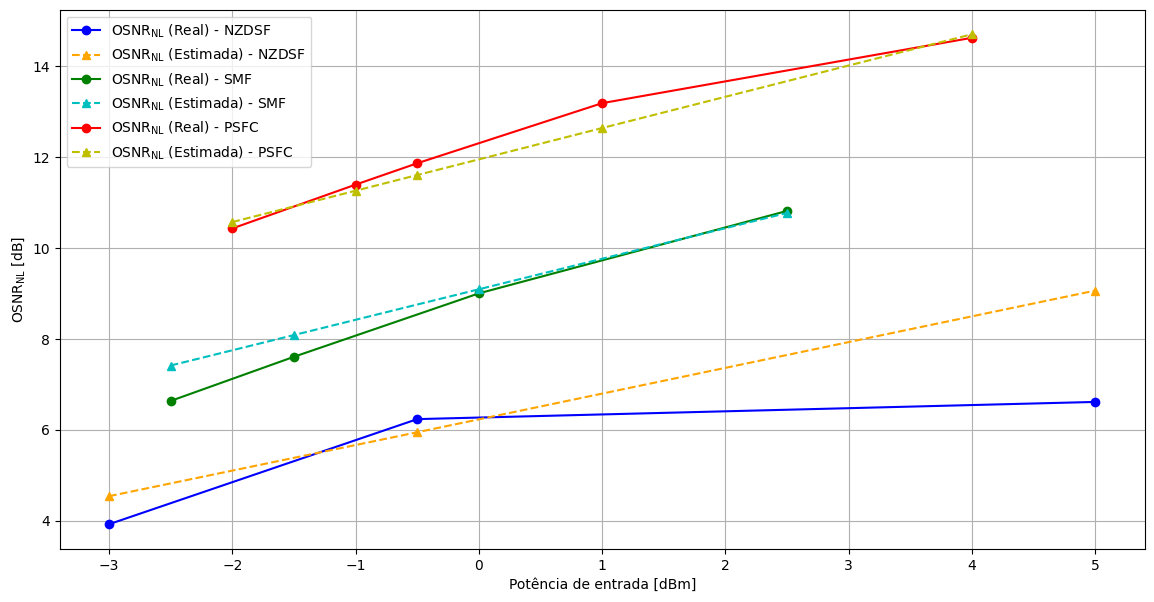

In [18]:
fig, ax = plt.subplots(figsize=(14,7))
for DispPar in [3.8, 16.7, 20.1 ]:   
    df_filtrado = df_to_plot_predict[df_to_plot_predict['DispPar'] == DispPar]
    df_to_plot = filtrar(df_filtrado, **{
        'NumCh': 13,
        'Spans_L': 110,
        'NumSpans': 12,
        'coef_mod_Spans_ModFormatCh_1': 1/12,
        'coef_mod_Spans_ModFormatIntLeft_1': 1/12,
        'coef_mod_Spans_ModFormatIntRight_1': 1/12,
        })
    df_to_plot=df_to_plot.sort_values(by='Spans_PdBmCh')
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL'], label=f'{osnr_label} (Real) - {DisPar_to_Fiber[DispPar]}', marker='o', color=color_per_fiber[DisPar_to_Fiber[DispPar]][0])
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL_pred'], linestyle='--', label=f'{osnr_label} (Estimada) - {DisPar_to_Fiber[DispPar]}', marker='^', color=color_per_fiber[DisPar_to_Fiber[DispPar]][1])

ax.set(xlabel='Potência de entrada [dBm]', ylabel= osnr_label + ' [dB]')
ax.legend(loc='upper left')
ax.grid()
plt.show()

In [19]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')

for channel in string_features:
  for key in coef_mod.keys():
    df[f'coef_mod_{channel}_{key}'] = df[channel].apply(lambda x: coef_mod[key][x])
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])
    

In [20]:
X_validation = df_val[features].drop(columns=coef_mod0)
y_validation = df_val[output_features]

y_validation2 = y_validation.copy()
y_validation2['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL.predict(X_validation)


df_to_plot_predict = X_validation.copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2

In [21]:
result_osnr_sfs = model_evaluation(df_to_plot_predict['OSNRdB_NL_pred'], df_to_plot_predict['OSNRdB_NL'], X_train)
result_osnr_sfs

{'R²': 0.291, 'R²a': 0.23996, 'MSE': 9.64478, 'RMSE': 3.1056, 'MAE': 1.83248}

c:\Users\Victor\Documents\UFPE\transmission_quality_in_optical_networks\utils.py:230: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


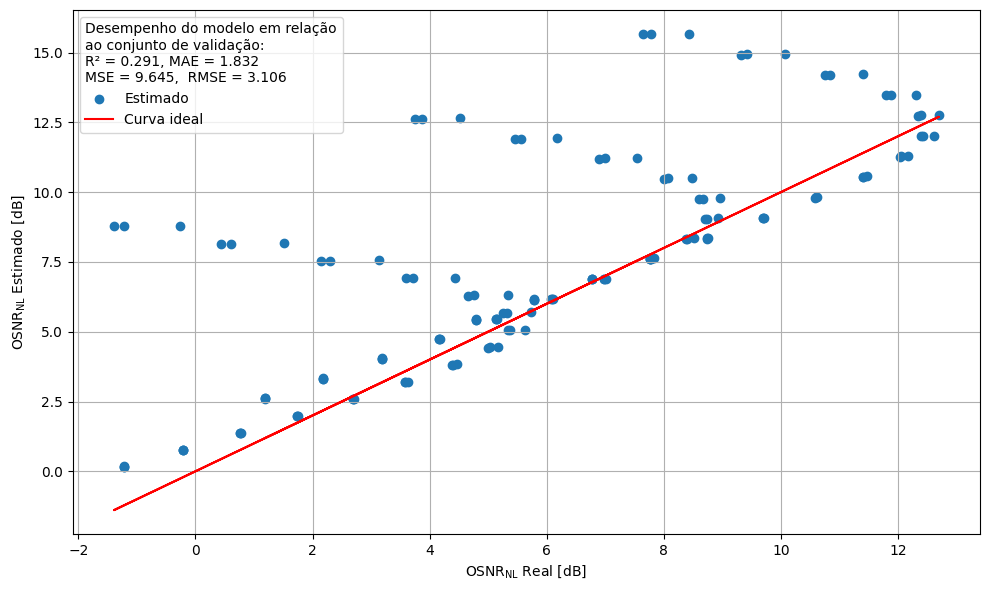

In [26]:
for key, value in result_osnr_sfs.items():
    result_osnr_sfs[key] = round(value ,3)
plot_scatter_comp(df_to_plot_predict, 'OSNRdB_NL', result_osnr_sfs, validation_mode=True)

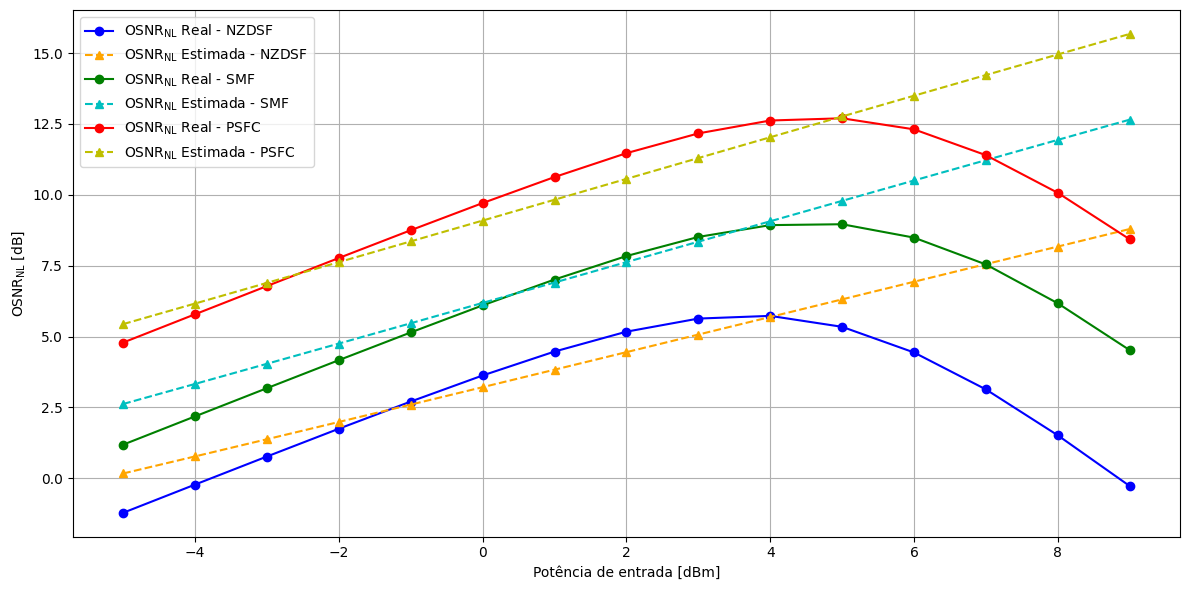

In [23]:
idx = 0
fig, ax = plt.subplots(figsize=(12, 6))
for fiberParam in to_plot_params:
  dfplot = df_to_plot_predict.copy()
  df_to_plot = dfplot[(dfplot['coef_mod_Spans_ModFormatCh_1'] == fiberParam['coef_mod_Spans_ModFormatCh_1']) & (dfplot['DispPar'] == fiberParam['DispPar'])]
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL'], label=f'{osnr_label} Real - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='o', color=color1[idx])
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL_pred'], linestyle='--', label=f'{osnr_label} Estimada - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='^', color=color2[idx])
  ax.legend(loc='upper left')
  idx +=1

ax.set(xlabel=f'Potência de entrada [dBm]', ylabel=f'{osnr_label} [dB]')

fig.tight_layout()
ax.grid()
plt.show()

#### Validação Cruzada

In [24]:
model_svmRbf_OSNRdB_NL = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [25]:
scores_cross_validation_SVMRBF_OSNRdBNL = crossval_scores(model_svmRbf_OSNRdB_NL, X_features, y_features.OSNRdB_NL)
scores_cross_validation_SVMRBF_OSNRdBNL

Score for fold 1: {'R²': 0.95023, 'R²a': 0.95018, 'MSE': 0.758, 'RMSE': 0.87063, 'MAE': 0.59248}
Score for fold 2: {'R²': 0.95408, 'R²a': 0.95404, 'MSE': 0.72596, 'RMSE': 0.85203, 'MAE': 0.58344}
Score for fold 3: {'R²': 0.94998, 'R²a': 0.94993, 'MSE': 0.75886, 'RMSE': 0.87113, 'MAE': 0.59298}
Score for fold 4: {'R²': 0.94672, 'R²a': 0.94667, 'MSE': 0.81429, 'RMSE': 0.90238, 'MAE': 0.6103}
Score for fold 5: {'R²': 0.95226, 'R²a': 0.95222, 'MSE': 0.72709, 'RMSE': 0.8527, 'MAE': 0.58002}


{'R²': [0.95023, 0.95408, 0.94998, 0.94672, 0.95226],
 'MAE': [0.59248, 0.58344, 0.59298, 0.6103, 0.58002],
 'MSE': [0.758, 0.72596, 0.75886, 0.81429, 0.72709],
 'MEAN_MAE': 0.591844,
 'MEAN_MSE': 0.75684,
 'MEAN_R2': 0.9506540000000001}

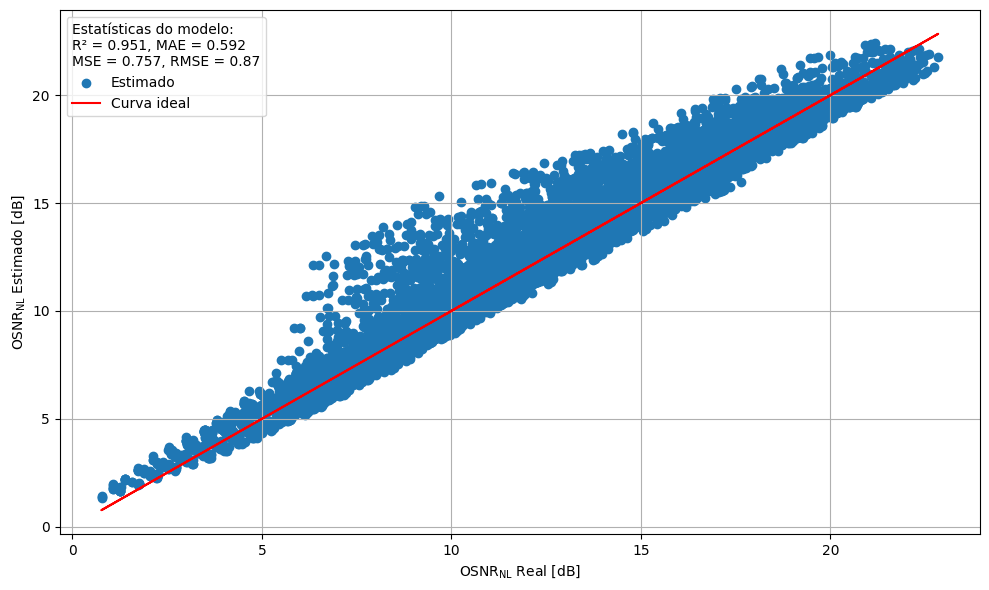

In [27]:
results_cv = {
    'R²': round(scores_cross_validation_SVMRBF_OSNRdBNL['MEAN_R2'], 3),
    'MSE': round(scores_cross_validation_SVMRBF_OSNRdBNL['MEAN_MSE'], 3),
    'MAE': round(scores_cross_validation_SVMRBF_OSNRdBNL['MEAN_MAE'], 3)
}
plot_scatter_comp(df_svmRbf_OSRNdBNL, 'OSNRdB_NL', results_cv)

### KNN - Estimação da Potência do ruído não linear (dB)


#### Simulação Isolada

In [28]:
model_svnRBF_regressor_NLIN = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.3)
model_svnRBF_regressor_NLIN.fit(X_train, y_train.NLIN_Power)
#dump(model_svnRBF_regressor_NLIN, save_base_path + 'modelo_SVMRBF_NLIN.joblib')
df_svmRBF_NLIN = y_test.copy()[['NLIN_Power']]

In [30]:
df_svmRBF_NLIN['NLIN_Power_pred'] = model_svnRBF_regressor_NLIN.predict(X_test)
model_evaluation(df_svmRBF_NLIN['NLIN_Power_pred'], df_svmRBF_NLIN['NLIN_Power'], X_test)

{'R²': 0.99387,
 'R²a': 0.99387,
 'MSE': 0.43519,
 'RMSE': 0.65969,
 'MAE': 0.51073}

In [ ]:
y_test = y_test.copy()
y_validation2 = y_test.copy()
y_validation2['NLIN_Power_pred'] = model_svnRBF_regressor_NLIN.predict(X_test)

In [ ]:
df_to_plot_predict = X_features.loc[X_test.index].copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2

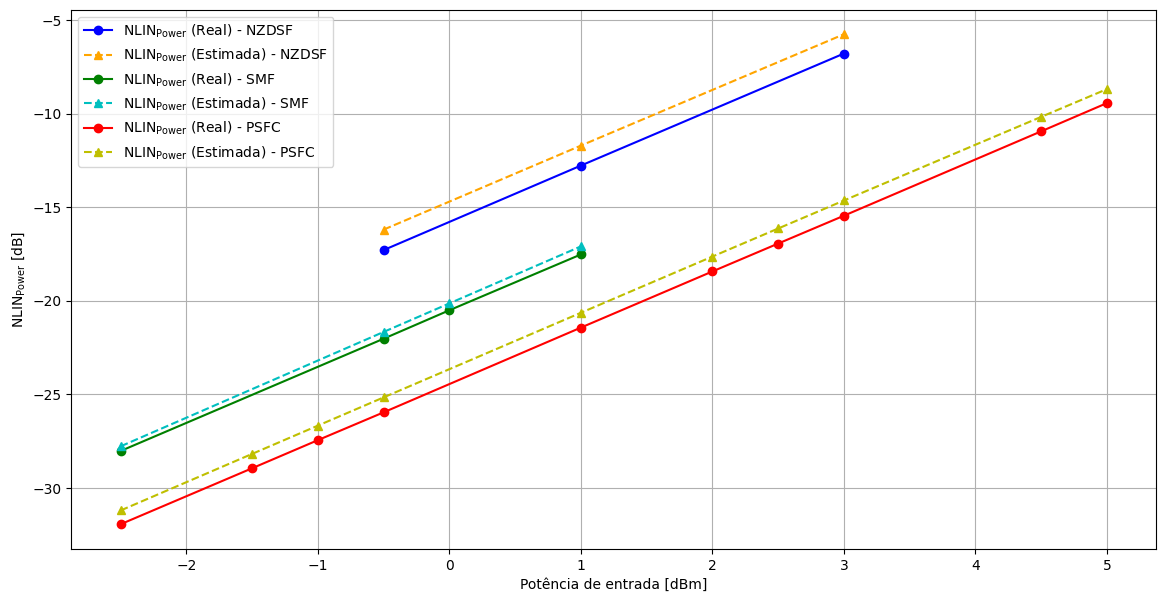

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
for DispPar in [3.8, 16.7, 20.1 ]:   
    df_filtrado = df_to_plot_predict[df_to_plot_predict['DispPar'] == DispPar]
    df_to_plot = filtrar(df_filtrado, **{
        'NumCh': 11,
        'Spans_L': 100,
        'NumSpans': 13,
        'coef_mod_Spans_ModFormatCh_1': 1/4,
        'coef_mod_Spans_ModFormatIntLeft_1': 1/4,
        'coef_mod_Spans_ModFormatIntRight_1': 1/4,
        })
    df_to_plot=df_to_plot.sort_values(by='Spans_PdBmCh')
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power'], label=f'{nlin_label} (Real) - {DisPar_to_Fiber[DispPar]}', marker='o', color=color_per_fiber[DisPar_to_Fiber[DispPar]][0])
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power_pred'], linestyle='--', label=f'{nlin_label} (Estimada) - {DisPar_to_Fiber[DispPar]}', marker='^', color=color_per_fiber[DisPar_to_Fiber[DispPar]][1])

ax.set(xlabel='Potência de entrada [dBm]', ylabel= f'{nlin_label} [dB]')
ax.legend(loc='upper left')
ax.grid()
plt.show()

In [ ]:
to_plot_params = [
    {
    'coef_mod_Spans_ModFormatCh_1': 1/8,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/8,
    'coef_mod_Spans_ModFormatIntRight_1': 1/8,
    'DispPar': 3.8,
    'Spans_gamma': 1.5,
    'Spans_alpha': 0.22
    },
    {
    'coef_mod_Spans_ModFormatCh_1': 1/8,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/8,
    'coef_mod_Spans_ModFormatIntRight_1': 1/8,
    'DispPar': 16.7,
    'Spans_gamma': 1.3,
    'Spans_alpha': 0.2
    },
    {
    'coef_mod_Spans_ModFormatCh_1': 1/8,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/8,
    'coef_mod_Spans_ModFormatIntRight_1': 1/8,
    'DispPar': 20.1,
    'Spans_gamma': 0.8,
    'Spans_alpha': 0.17
    }

]

In [31]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

X_validation = df_val[features].drop(columns=coef_mod0)
X_validation2 = X_validation.copy()

In [32]:
y_validation = df_val[output_features]
y_validation2 = y_validation.copy()
y_validation2['NLIN_Power_pred'] = model_svnRBF_regressor_NLIN.predict(X_validation)


df_to_plot_predict = X_validation2.copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2

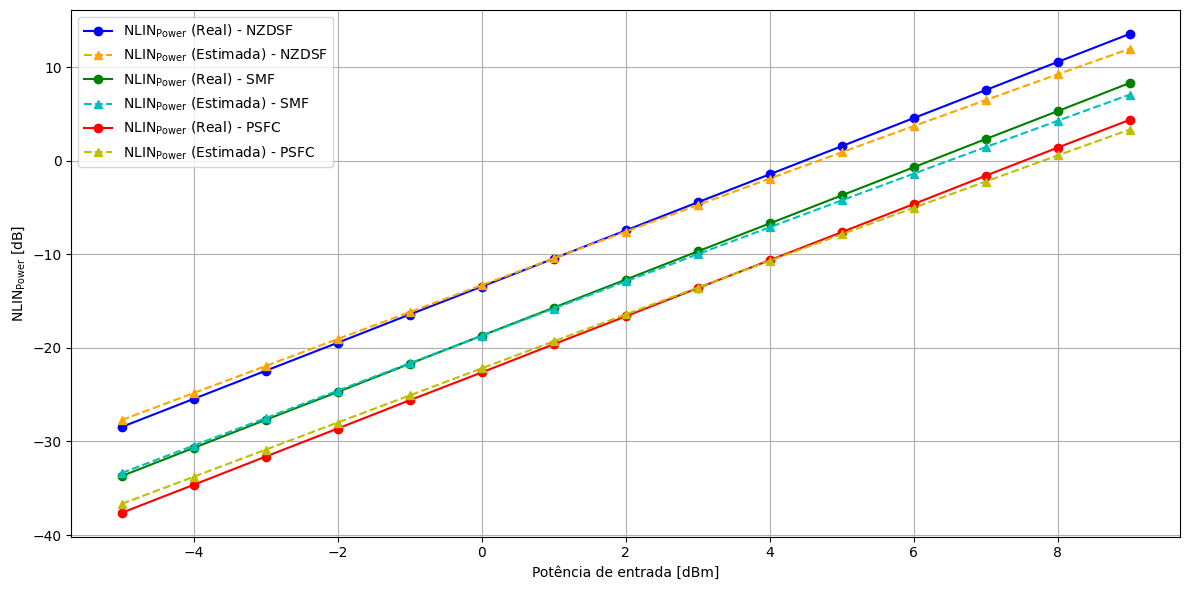

In [ ]:
idx = 0
fig, ax = plt.subplots(figsize=(12, 6))
for fiberParam in to_plot_params:
  dfplot = df_to_plot_predict.copy()
  df_to_plot = dfplot[(dfplot['coef_mod_Spans_ModFormatCh_1'] == fiberParam['coef_mod_Spans_ModFormatCh_1']) & (dfplot['DispPar'] == fiberParam['DispPar'])]
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power'], label=f'{nlin_label} (Real) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='o', color=color1[idx])
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power_pred'], linestyle='--', label=f'{nlin_label} (Estimada) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='^', color=color2[idx])
  ax.legend(loc='upper left')
  idx +=1

ax.set(xlabel=f'Potência de entrada [dBm]', ylabel=f'{nlin_label} [dB]')

fig.tight_layout()
ax.grid()
plt.show()

In [33]:
model_evaluation(df_to_plot_predict['NLIN_Power_pred'], df_to_plot_predict['NLIN_Power'], X_train)

{'R²': 0.99714,
 'R²a': 0.99694,
 'MSE': 0.52014,
 'RMSE': 0.72121,
 'MAE': 0.58326}

c:\Users\Victor\Documents\UFPE\transmission_quality_in_optical_networks\utils.py:230: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


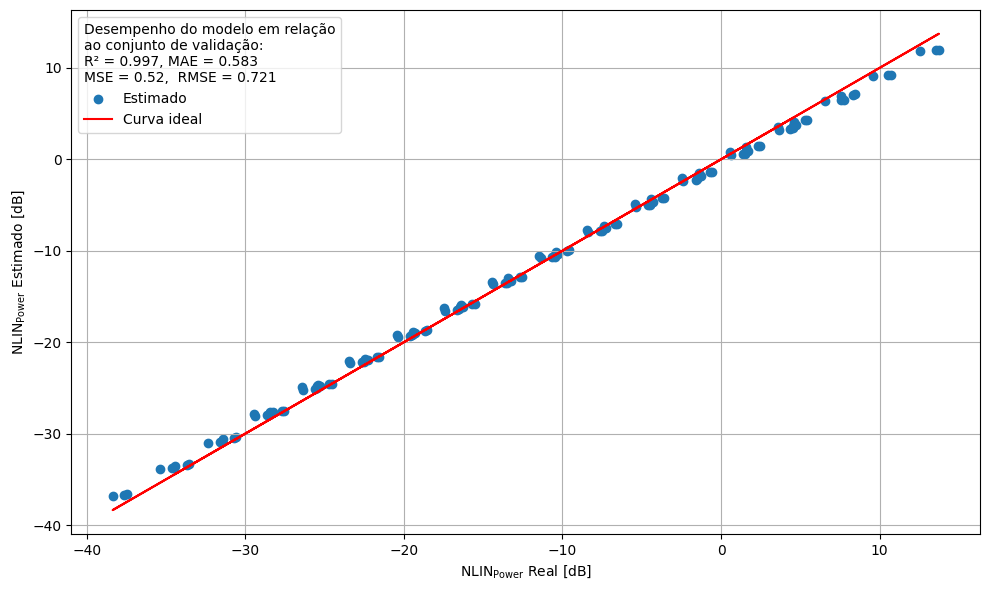

In [37]:
plot_scatter_comp(df_to_plot_predict, 'NLIN_Power', 
    {   'R²': 0.997,
        'MSE': 0.520,
        'MAE': 0.583
    }, validation_mode=True
 )

#### Validação Cruzada

In [ ]:
svm_regressor_rfb = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [ ]:
scores_cross_validation_SVMRFB_NLIN = crossval_scores(svm_regressor_rfb, X_features, y_features.NLIN_Power)
scores_cross_validation_SVMRFB_NLIN

Score for fold 1: {'R²': 0.99415, 'R²a': 0.99414, 'MSE': 0.41023, 'RMSE': 0.64049, 'MAE': 0.4941}
Score for fold 2: {'R²': 0.99433, 'R²a': 0.99433, 'MSE': 0.40552, 'RMSE': 0.63681, 'MAE': 0.49035}
Score for fold 3: {'R²': 0.99418, 'R²a': 0.99418, 'MSE': 0.39807, 'RMSE': 0.63093, 'MAE': 0.48734}
Score for fold 4: {'R²': 0.99442, 'R²a': 0.99441, 'MSE': 0.39707, 'RMSE': 0.63014, 'MAE': 0.48669}
Score for fold 5: {'R²': 0.99454, 'R²a': 0.99453, 'MSE': 0.39209, 'RMSE': 0.62617, 'MAE': 0.48556}


{'R²': [0.99415, 0.99433, 0.99418, 0.99442, 0.99454],
 'MAE': [0.4941, 0.49035, 0.48734, 0.48669, 0.48556],
 'MSE': [0.41023, 0.40552, 0.39807, 0.39707, 0.39209],
 'MEAN_MAE': 0.488808,
 'MEAN_MSE': 0.400596,
 'MEAN_R2': 0.994324}

In [43]:
def plot_scatter_comp(df, target, result_model_evaluation, figsize=(10,6), validation_mode = False):
  fig, ax = plt.subplots(figsize=figsize)
  label = {
    'OSNRdB_NL': r'$\mathrm{OSNR}_{\mathrm{NL}}$',
    'NLIN_Power': r'$\mathrm{NLIN}_{\mathrm{Power}}$'
  }[target]
  if validation_mode:
    title = f"Desempenho do modelo em relação\nao conjunto de validação:\nR² = {result_model_evaluation['R²']}, MAE = {result_model_evaluation['MAE']}\nMSE = {result_model_evaluation['MSE']},  RMSE = {round(result_model_evaluation['MSE']**0.5, 3)}"
  else:
    title= f"Estatísticas do modelo:\nR² = {result_model_evaluation['R²']}, MAE = {result_model_evaluation['MAE']}\nMSE = {result_model_evaluation['MSE']}, RMSE = {round(result_model_evaluation['MSE']**0.5, 3)}"
  
  target_pred = target + '_pred'
  ax.scatter(df[target], df[target_pred], label = 'Estimado')
  ax.plot(df[target], df[target], label=f'Curva ideal', color='r')
  ax.set(xlabel=f'{label} Real [dB]', ylabel=f'{label} Estimado [dB]')
  ax.legend(
    alignment='left', loc='upper left', title=title)
  ax.grid()
  fig.tight_layout()
  fig.show()

C:\Users\Victor\AppData\Local\Temp\ipykernel_21192\2940489906.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


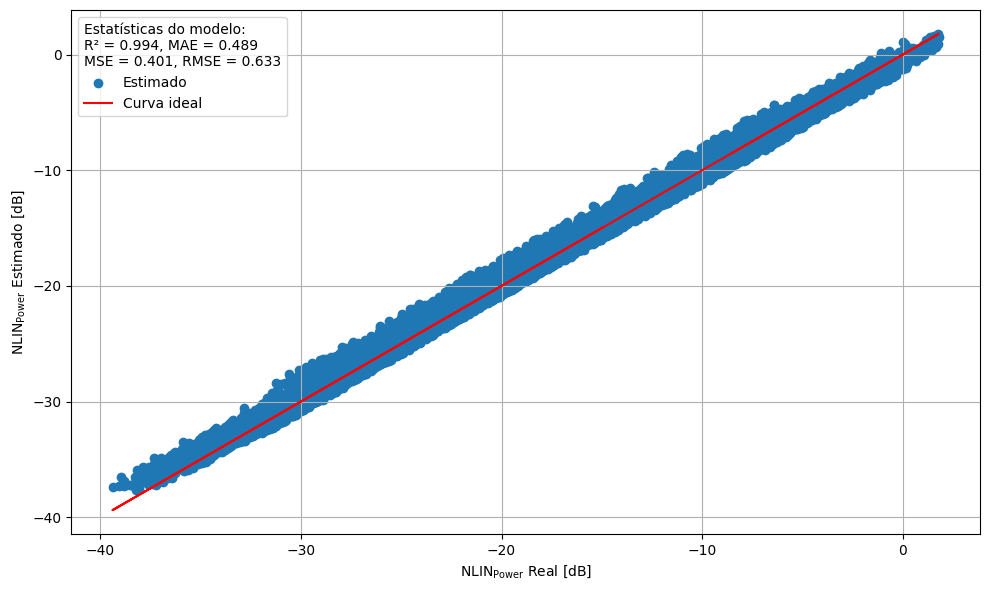

In [44]:
results_ = {
    'R²': 0.994,
    'MSE': 0.401,
    'MAE': 0.489
}
plot_scatter_comp(df_svmRBF_NLIN, 'NLIN_Power', results_)

# Simulações com feature scaling

#### Aplicação de métodos de normalização dos atributos e avaliação dos modelos.

In [45]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [46]:
X_features_scaled = X_features.copy()
scaler = scale.fit(X_features)

In [47]:
X_features_scaled[X_features.columns] = scaler.transform(X_features)

### Estimação da Relação Sinal-Ruído com degradações não lineares (dB)

#### Simulação Isolado

In [48]:
X_features_scaled = X_features.copy()
X_features_scaled[X_features.columns] = scale.fit_transform(X_features)

In [49]:
#Intancia do modelo
model_svmRbf_OSNRdB_NL_scaled = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [50]:
#Separação entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_features, test_size=0.3)
model_svmRbf_OSNRdB_NL_scaled.fit(X_train, y_train.OSNRdB_NL)
#dump(model_svmRbf_OSNRdB_NL_scaled, save_base_path + 'modelo_SVMRBF_OSNRdBNL_scaled.joblib')
df_svmRbf_OSNRdBNL_scaled = y_test.copy()[['OSNRdB_NL']]

In [51]:
df_svmRbf_OSNRdBNL_scaled['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL_scaled.predict(X_test)
result_osnr_scaled = model_evaluation(df_svmRbf_OSNRdBNL_scaled['OSNRdB_NL_pred'], df_svmRbf_OSNRdBNL_scaled['OSNRdB_NL'], X_test)
result_osnr_scaled

{'R²': 0.99994,
 'R²a': 0.99994,
 'MSE': 0.00097,
 'RMSE': 0.03122,
 'MAE': 0.01947}

In [57]:
results_ = {
    'R²': 0.999,
    'MSE': 0.013,
    'MAE': 0.070
}

C:\Users\Victor\AppData\Local\Temp\ipykernel_21192\2940489906.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


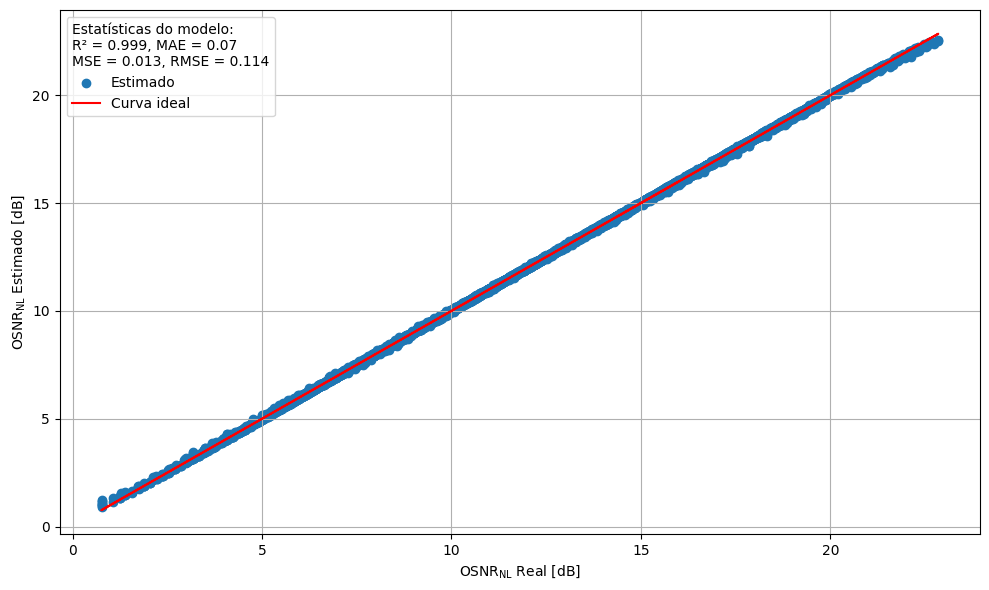

In [58]:
plot_scatter_comp(df_svmRbf_OSNRdBNL_scaled, 'OSNRdB_NL', results_)

In [ ]:
y_test = y_test.copy()
y_validation2 = y_test.copy()
y_validation2['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL_scaled.predict(X_test)

df_to_plot_predict = X_features.loc[X_test.index].copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2

In [ ]:
model_evaluation(df_to_plot_predict['OSNRdB_NL_pred'], df_to_plot_predict['OSNRdB_NL'], X_train)

{'R²': 0.99994,
 'R²a': 0.99994,
 'MSE': 0.00101,
 'RMSE': 0.03174,
 'MAE': 0.01979}

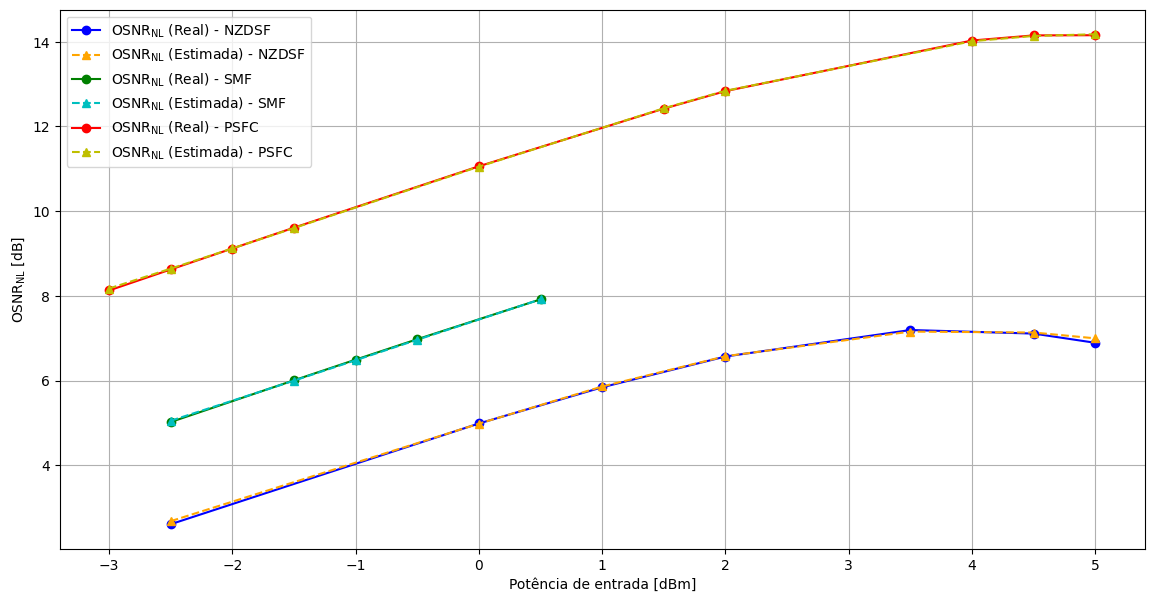

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
for DispPar in [3.8, 16.7, 20.1 ]:   
    df_filtrado = df_to_plot_predict[df_to_plot_predict['DispPar'] == DispPar]
    df_to_plot = filtrar(df_filtrado, **{
        'NumCh': 15,
        'Spans_L': 120,
        'NumSpans': 11,
        'coef_mod_Spans_ModFormatCh_1': 1/4,
        'coef_mod_Spans_ModFormatIntLeft_1': 1/4,
        'coef_mod_Spans_ModFormatIntRight_1': 1/4,
        })
    df_to_plot=df_to_plot.sort_values(by='Spans_PdBmCh')
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL'], label=f'{osnr_label} (Real) - {DisPar_to_Fiber[DispPar]}', marker='o', color=color_per_fiber[DisPar_to_Fiber[DispPar]][0])
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL_pred'], linestyle='--', label=f'{osnr_label} (Estimada) - {DisPar_to_Fiber[DispPar]}', marker='^', color=color_per_fiber[DisPar_to_Fiber[DispPar]][1])

ax.set(xlabel='Potência de entrada [dBm]', ylabel= f'{osnr_label} [dB]')
ax.legend(loc='upper left')
ax.grid()
plt.show()

In [52]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

In [53]:
X_validation = df_val[features].drop(columns=coef_mod0)
X_validation2 = X_validation.copy()

X_validation[X_validation.columns] = scaler.transform(X_validation2)

y_validation = df_val[output_features]
y_validation2 = y_validation.copy()
y_validation2['OSNRdB_NL_pred'] = model_svmRbf_OSNRdB_NL_scaled.predict(X_validation)


df_to_plot_predict = X_validation2.copy()
df_to_plot_predict[output_features + ['OSNRdB_NL_pred']] = y_validation2

result_osnr_scaled_val = model_evaluation(df_to_plot_predict['OSNRdB_NL_pred'], df_to_plot_predict['OSNRdB_NL'], X_train)

In [54]:
for key, value in result_osnr_scaled_val.items():
    result_osnr_scaled_val[key] = round(value, 3)

C:\Users\Victor\AppData\Local\Temp\ipykernel_21192\2940489906.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


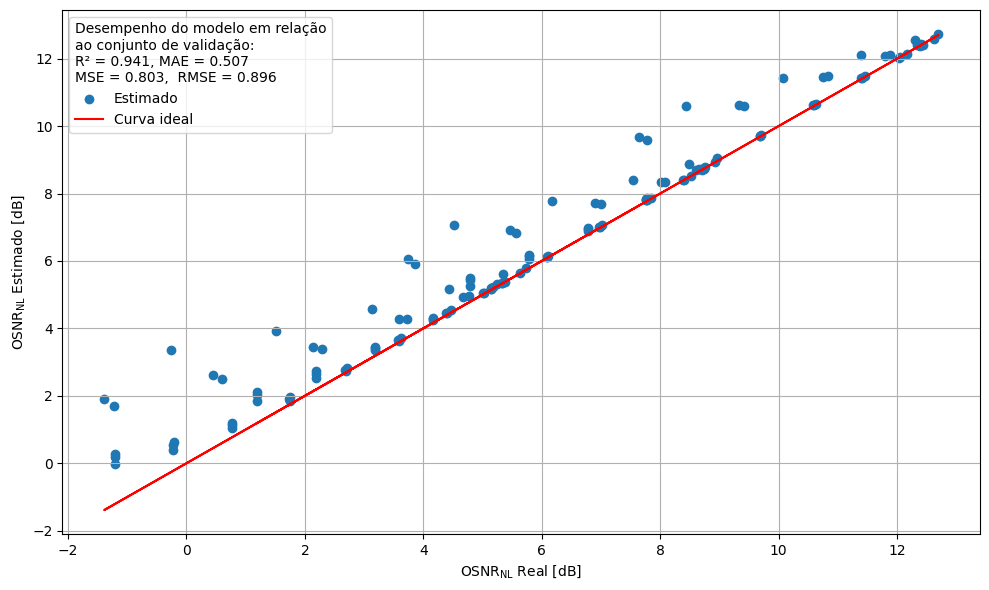

In [55]:
plot_scatter_comp(df_to_plot_predict, 'OSNRdB_NL', result_osnr_scaled_val, validation_mode=True)

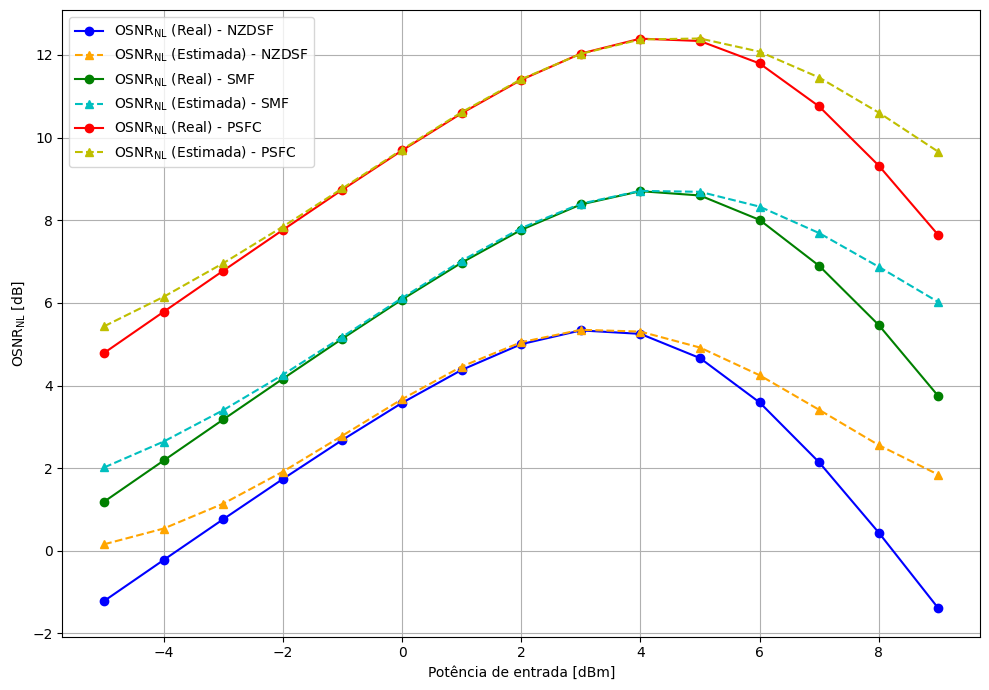

In [ ]:
idx = 0
fig, ax = plt.subplots(figsize=(10, 7))
for fiberParam in to_plot_params:
  dfplot = df_to_plot_predict.copy()
  df_to_plot = dfplot[(dfplot['coef_mod_Spans_ModFormatCh_1'] == fiberParam['coef_mod_Spans_ModFormatCh_1']) & (dfplot['DispPar'] == fiberParam['DispPar'])]
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL'], label=f'{osnr_label} (Real) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='o', color=color1[idx])
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['OSNRdB_NL_pred'], linestyle='--', label=f'{osnr_label} (Estimada) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='^', color=color2[idx])
  ax.legend(loc='upper left')
  idx +=1

ax.set(xlabel=f'Potência de entrada [dBm]', ylabel=f'{osnr_label} [dB]')

fig.tight_layout()
ax.grid()
plt.show()

#### Validação Cruzada

In [ ]:
model_svmRbf_OSNRdB_NL_scaled = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [ ]:

scores_cross_validation_KNN_OSNRdBNL_scaled = cross_validation_scores(model_svmRbf_OSNRdB_NL_scaled, X_features_scaled, y_features, 'OSNRdB_NL')
scores_cross_validation_KNN_OSNRdBNL_scaled

{'MSE Scores:': array([0.02833783, 0.00118361, 0.00062841, 0.00139163, 0.03363265]),
 'MAE Scores:': array([0.13470628, 0.02721863, 0.01886705, 0.02812783, 0.13883154]),
 'R2 Scores:': array([0.99684151, 0.99987241, 0.99993764, 0.99987599, 0.99732422]),
 'RMSE Scores:': array([0.16833843, 0.03440367, 0.0250681 , 0.03730453, 0.18339206]),
 'MSE Mean:': 0.013034825225126967,
 'MAE Mean:': 0.06955026784197449,
 'KNN R2 Mean:': 0.9987703518938804,
 'KNN RMSE Mean:': 0.08970135790388319}

In [ ]:
results_ = {
    'R²': 0.999,
    'MSE': 0.013,
    'MAE': 0.070
}

### SVM Kernel RBF - Estimação da Potência do ruído não linear (dB)



#### Simulação Isolada

In [59]:
model_svmRbf_NLIN_scaled = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_features, test_size=0.3)
model_svmRbf_NLIN_scaled.fit(X_train, y_train.NLIN_Power)
#dump(model_svmRbf_NLIN_scaled, save_base_path + 'modelo_SVMRBF_NLIN_scaled.joblib')




SVR(coef0=1.25, epsilon=0.01)

In [61]:
df_svmRbf_NLIN_scaled = y_test.copy()[['NLIN_Power']]
df_svmRbf_NLIN_scaled['NLIN_Power_pred'] = model_svmRbf_NLIN_scaled.predict(X_test)
result_nlin_scaled = model_evaluation(df_svmRbf_NLIN_scaled['NLIN_Power_pred'], df_svmRbf_NLIN_scaled['NLIN_Power'], X_test)
result_nlin_scaled

{'R²': 0.9999, 'R²a': 0.9999, 'MSE': 0.00683, 'RMSE': 0.08266, 'MAE': 0.0418}

C:\Users\Victor\AppData\Local\Temp\ipykernel_21192\2940489906.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


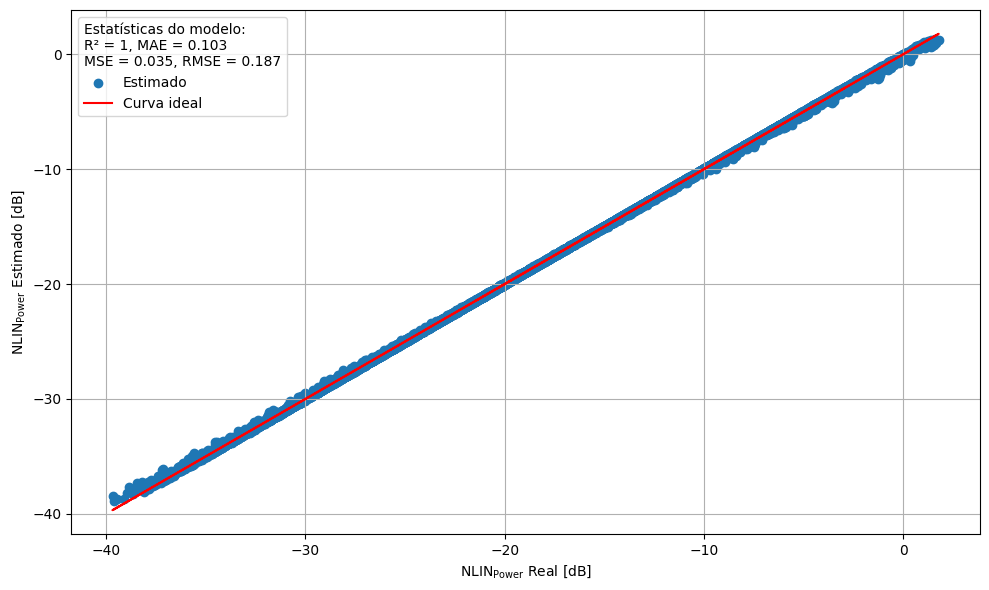

In [67]:
results_ = {
    'R²': 1,
    'MSE': 0.035,
    'MAE': 0.103
}
plot_scatter_comp(df_svmRbf_NLIN_scaled, 'NLIN_Power', results_)

In [ ]:
y_test = y_test.copy()
y_validation2 = y_test.copy()
y_validation2['NLIN_Power_pred'] = model_svmRbf_NLIN_scaled.predict(X_test)


In [ ]:
df_to_plot_predict = X_features.loc[X_test.index].copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2

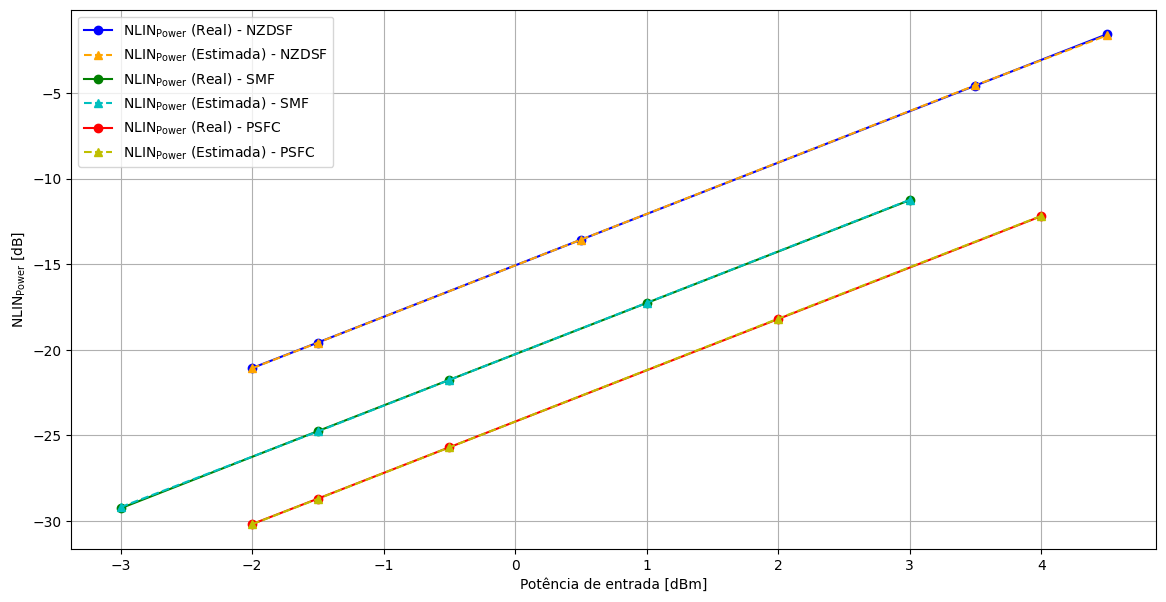

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
for DispPar in [3.8, 16.7, 20.1 ]:   
    df_filtrado = df_to_plot_predict[df_to_plot_predict['DispPar'] == DispPar]
    df_to_plot = filtrar(df_filtrado, **{
        'NumCh': 15,
        'Spans_L': 120,
        'NumSpans': 11,
        'coef_mod_Spans_ModFormatCh_1': 1/8,
        'coef_mod_Spans_ModFormatIntLeft_1': 1/8,
        'coef_mod_Spans_ModFormatIntRight_1': 1/8,
        })
    df_to_plot=df_to_plot.sort_values(by='Spans_PdBmCh')
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power'], label=f'{nlin_label} (Real) - {DisPar_to_Fiber[DispPar]}', marker='o', color=color_per_fiber[DisPar_to_Fiber[DispPar]][0])
    ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power_pred'], linestyle='--', label=f'{nlin_label} (Estimada) - {DisPar_to_Fiber[DispPar]}', marker='^', color=color_per_fiber[DisPar_to_Fiber[DispPar]][1])

ax.set(xlabel='Potência de entrada [dBm]', ylabel= f'{nlin_label} [dB]')
ax.legend(loc='upper left')
ax.grid()
plt.show()

In [62]:
df_val = pd.read_csv(r'data\Pchanel_variation.csv')
for channel in string_features:
  for key in coef_mod.keys():
    df_val[f'coef_mod_{channel}_{key}'] = df_val[channel].apply(lambda x: coef_mod[key][x])

In [63]:
X_validation = df_val[features].drop(columns=coef_mod0)
X_validation2 = X_validation.copy()

X_validation[X_validation.columns] = scale.transform(X_validation2)
y_validation = df_val[output_features]

y_validation2 = y_validation.copy()
y_validation2['NLIN_Power_pred'] = model_svmRbf_NLIN_scaled.predict(X_validation)

df_to_plot_predict = X_validation2.copy()
df_to_plot_predict[output_features + ['NLIN_Power_pred']] = y_validation2

In [64]:
result_nlin_scaled_val = model_evaluation(df_to_plot_predict['NLIN_Power_pred'], df_to_plot_predict['NLIN_Power'], X_train)
result_nlin_scaled_val

{'R²': 0.96621,
 'R²a': 0.96377,
 'MSE': 6.15394,
 'RMSE': 2.48071,
 'MAE': 1.35111}

C:\Users\Victor\AppData\Local\Temp\ipykernel_21192\2940489906.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


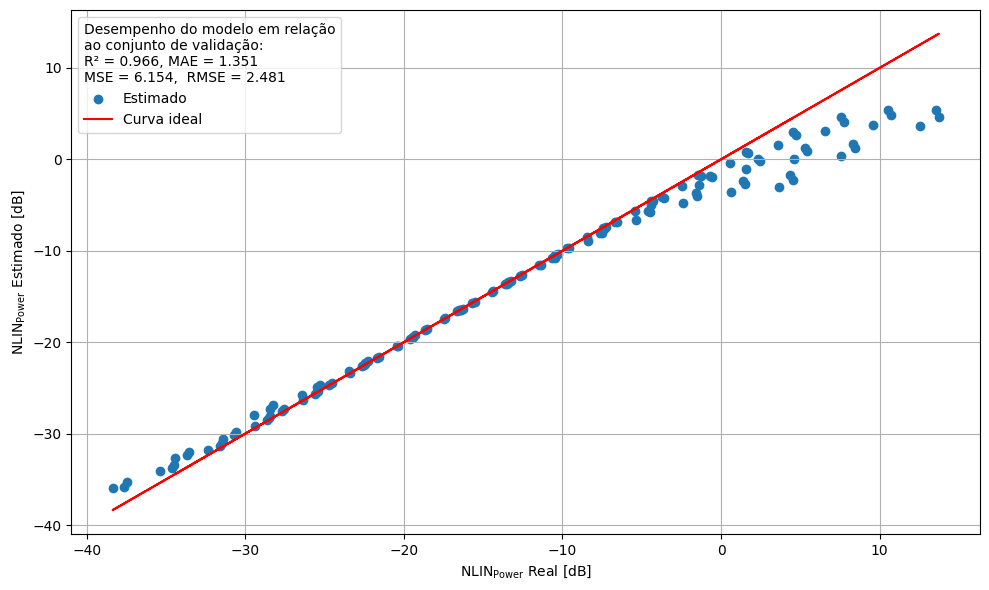

In [65]:
for key, value in result_nlin_scaled_val.items():
    result_nlin_scaled_val[key] = round(value, 3)

plot_scatter_comp(df_to_plot_predict, 'NLIN_Power', result_nlin_scaled_val, validation_mode=True)

In [ ]:
to_plot_params = [
    {
    'coef_mod_Spans_ModFormatCh_1': 1/12,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/12,
    'coef_mod_Spans_ModFormatIntRight_1': 1/12,
    'DispPar': 3.8,
    'Spans_gamma': 1.5,
    'Spans_alpha': 0.22
    },
    {
    'coef_mod_Spans_ModFormatCh_1': 1/12,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/12,
    'coef_mod_Spans_ModFormatIntRight_1': 1/12,
    'DispPar': 16.7,
    'Spans_gamma': 1.3,
    'Spans_alpha': 0.2
    },
    {
    'coef_mod_Spans_ModFormatCh_1': 1/12,
    'coef_mod_Spans_ModFormatIntLeft_1': 1/12,
    'coef_mod_Spans_ModFormatIntRight_1': 1/12,
    'DispPar': 20.1,
    'Spans_gamma': 0.8,
    'Spans_alpha': 0.17
    }

]

In [ ]:
df_to_plot_predict.head()

,NumCh,NumSpans,DispPar,Spans_gamma,Spans_beta2,Spans_alpha,Spans_L,Spans_PdBmCh,coef_mod_Spans_ModFormatCh_1,coef_mod_Spans_ModFormatIntLeft_1,coef_mod_Spans_ModFormatIntRight_1,NLIN_Power,PChOptdBm,OSNRdB_NL,BER_NL,OSNRdB,BER,NLIN_Power_pred
0,15,15,16.7,1.3,21.299985,0.2,120,-5.0,0.25,0.25,0.25,-34.418869,4.572837,1.189623,0.221771,1.192538,0.221694,-32.681432
1,15,15,16.7,1.3,21.299985,0.2,120,-4.0,0.25,0.25,0.25,-31.410121,4.569921,2.186711,0.195051,2.192538,0.194892,-30.600427
2,15,15,16.7,1.3,21.299985,0.2,120,-3.0,0.25,0.25,0.25,-28.418312,4.572651,3.180940,0.167609,3.192538,0.167286,-28.101726
3,15,15,16.7,1.3,21.299985,0.2,120,-2.0,0.25,0.25,0.25,-25.418260,4.572634,4.169428,0.140113,4.192538,0.139474,-25.331249
4,15,15,16.7,1.3,21.299985,0.2,120,-1.0,0.25,0.25,0.25,-22.424185,4.574609,5.146611,0.113449,5.192538,0.112222,-22.412629


In [ ]:
x_val_nlin = df_val[features].drop(columns=coef_mod0)
x_val_nlin_scaled = x_val_nlin.copy()

x_val_nlin_scaled[x_val_nlin.columns] = scale.transform(x_val_nlin_scaled)

y_val = df_val[output_features]

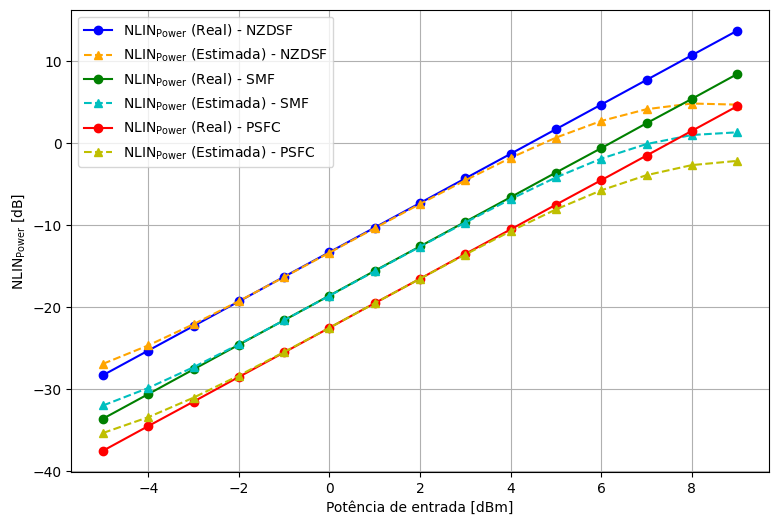

In [ ]:
plot_all_fiber_pdBmCh(x_val_nlin_scaled, y_val, model_svmRbf_NLIN_scaled, 'NLIN_Power', x_val_nlin, coef_mod=1/12, L=120, NSpam=15, NCh=15, scaled=True)

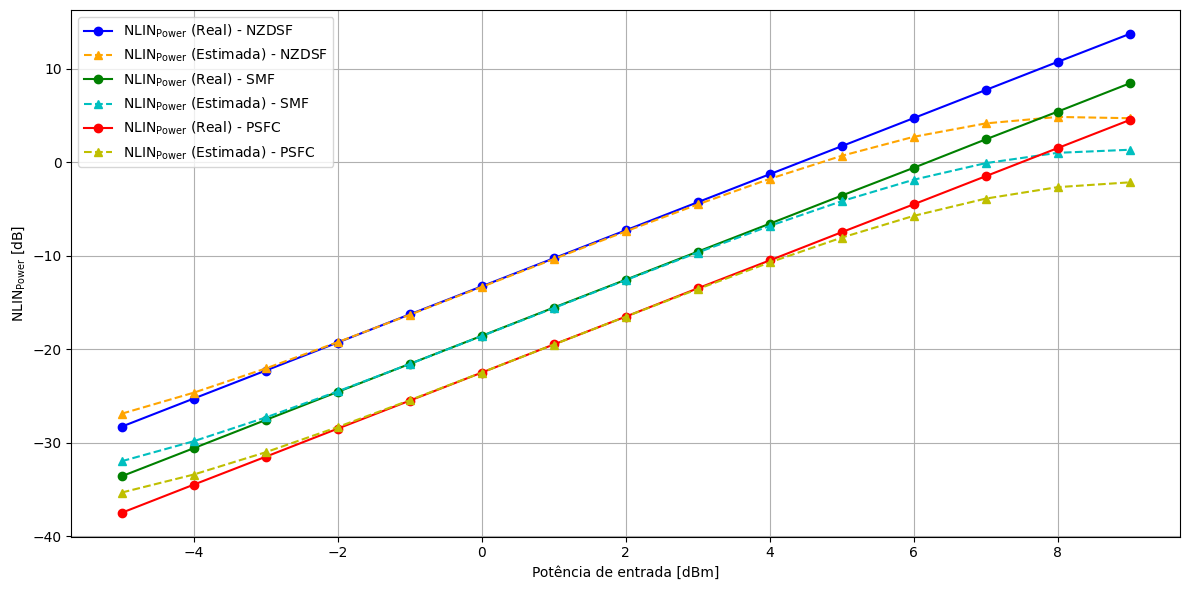

In [ ]:
idx = 0
fig, ax = plt.subplots(figsize=(12, 6))
for fiberParam in to_plot_params:
  dfplot = df_to_plot_predict.copy()
  df_to_plot = dfplot[(dfplot['coef_mod_Spans_ModFormatCh_1'] == fiberParam['coef_mod_Spans_ModFormatCh_1']) & (dfplot['DispPar'] == fiberParam['DispPar'])]
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power'], label=f'{nlin_label} (Real) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='o', color=color1[idx])
  ax.plot(df_to_plot['Spans_PdBmCh'], df_to_plot['NLIN_Power_pred'], linestyle='--', label=f'{nlin_label} (Estimada) - {DisPar_to_Fiber[fiberParam["DispPar"]]}', marker='^', color=color2[idx])
  ax.legend(loc='upper left')
  idx +=1

ax.set(xlabel=f'Potência de entrada [dBm]', ylabel=f'{nlin_label} [dB]')

fig.tight_layout()
ax.grid()
plt.show()

#### Validação Cruzada

In [ ]:
svmRbf_regressor_NLIN_scaled = SVR(kernel = 'rbf', epsilon=0.01, coef0=1.25)

In [ ]:
scores_cross_validation_svmRbf_NLIN_scalrd = cross_validation_scores(svmRbf_regressor_NLIN_scaled, X_features_scaled, y_features, 'NLIN_Power')
scores_cross_validation_svmRbf_NLIN_scalrd

{'MSE Scores:': array([0.08461164, 0.00345766, 0.00349352, 0.00346174, 0.08192235]),
 'MAE Scores:': array([0.19535814, 0.04333205, 0.04000401, 0.04321278, 0.19325585]),
 'R2 Scores:': array([0.99880554, 0.99995109, 0.99995052, 0.99995091, 0.99883714]),
 'MSE Mean:': 0.03538938279102252,
 'MAE Mean:': 0.10303256587102413,
 'KNN R2 Mean:': 0.999499041823495}

In [ ]:
results_ = {
    'R²': 1,
    'MSE': 0.035,
    'MAE': 0.103
}